In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np
import math

c:\Users\kwitv\Documents\MARC\SOCprediction\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = TabularDataset(f'Data/phil_socdata_train.csv')
train_data.head()

,SOC,V,I,T
0,100.000031,400.75,0.000000,15.5
1,100.000031,400.75,-0.270000,15.5
2,100.000031,400.75,-0.539999,15.5
3,100.000031,400.75,-0.809999,15.5
4,100.000031,400.75,-1.079998,15.5


In [3]:
label = 'SOC'
train_data[label].describe()

count    427326.000000
mean         67.759531
std          24.669208
min           0.000000
25%          48.627468
50%          72.941200
75%          88.627480
max         100.000031
Name: SOC, dtype: float64

In [4]:
#predictor = TabularPredictor(label=label).fit(train_data)

import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 30*60  # train various models for ~10 min
num_trials = 50  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor = TabularPredictor(label=label).fit(
    train_data, time_limit=time_limit, auto_stack=True,
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)


No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L2... Skipping this model.
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 99.77s of remaining time.
	-1.8667	 = Validation score   (-root_mean_squared_error)
	3.73s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 1704.03s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230327_160131\")


In [5]:
test_data = TabularDataset(f'Data/phil_socdata_test.csv')

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: Data/phil_socdata_test.csv | Columns = 4 / 4 | Rows = 18307 -> 18307


0    98.187317
1    98.187317
2    98.187317
3    98.187317
4    98.187317
Name: SOC, dtype: float32

In [6]:
predictor.evaluate(test_data, silent=True)

c:\Users\kwitv\Documents\MARC\SOCprediction\venv\lib\site-packages\autogluon\tabular\predictor\predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -3.433104709018858,
 'mean_squared_error': -11.786207943087458,
 'mean_absolute_error': -2.1855167705220993,
 'r2': 0.9817724438790423,
 'pearsonr': 0.9914858428878461,
 'median_absolute_error': -1.1812744180273427}

In [7]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L1\9faefecd,-2.266036,-2.693947,0.186905,0.001025,80.482304,0.186905,0.001025,80.482304,1,True,44
1,NeuralNetTorch_BAG_L1\23ef58bf,-2.346477,-2.685933,0.220650,0.001989,86.950814,0.220650,0.001989,86.950814,1,True,46
2,NeuralNetTorch_BAG_L1\3defa786,-2.388128,-2.706002,0.273805,0.002992,129.696980,0.273805,0.002992,129.696980,1,True,45
3,LightGBM_BAG_L1\T13,-2.629233,-2.477836,0.169576,0.001994,11.903371,0.169576,0.001994,11.903371,1,True,13
4,LightGBM_BAG_L1\T42,-2.644961,-2.456972,0.177013,0.001994,12.146817,0.177013,0.001994,12.146817,1,True,42
5,LightGBM_BAG_L1\T2,-2.665293,-2.343270,0.166574,0.001025,11.354635,0.166574,0.001025,11.354635,1,True,2
6,LightGBM_BAG_L1\T5,-2.674205,-2.642930,0.149112,0.001995,12.284622,0.149112,0.001995,12.284622,1,True,5
7,LightGBM_BAG_L1\T1,-2.682055,-2.431346,0.136145,0.001994,17.125572,0.136145,0.001994,17.125572,1,True,1
8,LightGBM_BAG_L1\T19,-2.691479,-2.473075,0.126684,0.000999,12.316741,0.126684,0.000999,12.316741,1,True,19
9,LightGBM_BAG_L1\T20,-2.704342,-2.406168,0.151173,0.000998,12.336567,0.151173,0.000998,12.336567,1,True,20


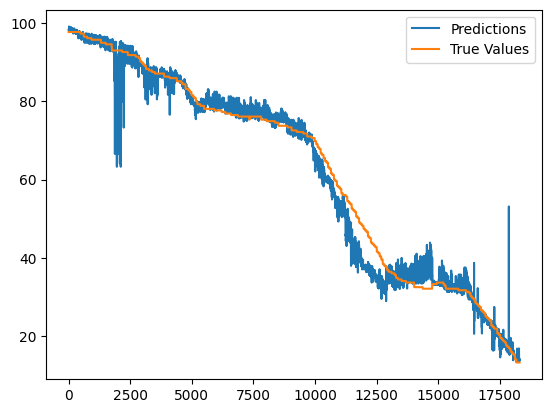

In [8]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()

In [9]:
mse_test = np.mean(((y_pred - test_data[label])**2))
rmse_test = math.sqrt(mse_test)
print("test data rmse", rmse_test)

test data rmse 3.433104709018858
